In [3]:
library(ggplot2)
# library(scatterpie)
# library(ggforce)
library(patchwork)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(scales)
library(extrafont)

# 3. 폰트 로드
loadfonts()

In [4]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_rect(color = "black", fill = NA, size = 0.6),  # size로 선 굵기 조절
            
            # panel.border = element_blank(),  
            
            # 축 설정
            # axis.line.x.top = element_line(color = "black", size = 0.3),  
            # axis.line.y.right = element_line(color = "black", size = 0.3),  
            # axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            # axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 메인 figure에 박스 추가
            # plot.background = element_rect(color = "black", fill = NA),
            
            # legend 박스 제거
            legend.box.background = element_blank(),  # 이전: element_rect(color = "black")
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(0.1, 0.1, 0.1, 0.1, unit = "mm")
        )
}

# 공통 색상 정의
color_values <- c(
    "fast" = "#E64B35",
    "slow" = "#4DBBD5",
    "similar" = "#7E7E7E"
)

In [5]:
# read *.frreg files in /data/jerrylee/pjt/BIGFAM.v.2.0/data/GS/po-sib/frreg

In [6]:
check_frreg_files <- function(
    cohort,
    base_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data",
    subdir = "po-sib/frreg"
) {
    # 파일 경로 생성
    frreg_path <- file.path(base_path, cohort, subdir)
    
    # .frreg 파일 리스트 불러오기
    files_list <- list.files(
        path = frreg_path, 
        pattern = "\\.frreg$",
        full.names = TRUE
    )
    
    # 2개의 파일이 있는 표현형 찾기
    phenotype_counts <- table(sapply(strsplit(basename(files_list), "\\."), `[`, 1))
    valid_phenos <- names(phenotype_counts[phenotype_counts == 2])
    
    for (file in files_list) {
        file_parts <- strsplit(basename(file), "\\.")[[1]]
        pheno_name <- file_parts[1]
        
        # 2개의 파일이 있는 표현형만 처리
        if (!(pheno_name %in% valid_phenos)) next
        
        df <- fread(file)
        
        # 각 DOR에 대해 slope ± 1.96*se 계산
        df$lower <- df$slope - 1.96 * df$se
        df$upper <- df$slope + 1.96 * df$se
        
        # 조건 확인
        invalid_rows <- which(df$lower < 0 | df$upper > 1)
        
        if (length(invalid_rows) > 0) {
            # cat(sprintf("\n표현형 %s 제외됨:\n", pheno_name))
            for (row in invalid_rows) {
                cat(sprintf("  DOR %d: slope = %.3f (%.3f - %.3f)\n",
                    df$DOR[row], df$slope[row], df$lower[row], df$upper[row]))
            }
            # invalid한 경우 해당 표현형 제외
            valid_phenos <- valid_phenos[valid_phenos != pheno_name]
        }
    }
    
    return(valid_phenos)
}

# 사용 예시:
ukb_valid <- check_frreg_files("UKB")
gs_valid <- check_frreg_files("GS")

  DOR 2: slope = 0.014 (-0.001 - 0.028)
  DOR 1: slope = -0.403 (-0.414 - -0.392)
  DOR 2: slope = -0.462 (-0.477 - -0.448)
  DOR 3: slope = 0.021 (-0.016 - 0.058)
  DOR 3: slope = -0.001 (-0.035 - 0.033)
  DOR 1: slope = -0.332 (-0.345 - -0.320)
  DOR 2: slope = -0.304 (-0.320 - -0.288)
  DOR 1: slope = -0.374 (-0.386 - -0.362)
  DOR 2: slope = -0.374 (-0.390 - -0.359)
  DOR 1: slope = -0.313 (-0.327 - -0.300)
  DOR 2: slope = -0.316 (-0.332 - -0.300)


# Step 1. Slope test results

In [67]:
read_slope_test_files <- function(
    cohort,
    base_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data",
    subdir = "po-sib/slope-test",
    significance_thresholds = c(lower = 2.5, upper = 97.5)
) {
    # 파일 경로 생성
    frreg_path <- file.path(base_path, cohort, subdir)
    
    # .slope 파일 리스트 불러오기
    files_list <- list.files(
        path = frreg_path, 
        pattern = "\\.slope$",  
        full.names = TRUE
    ) %>% 
        # .raw.slope 파일 제외
        .[!grepl("\\.raw\\.slope$", .)]
    
    # 파일이 없는 경우 에러 처리
    if (length(files_list) == 0) {
        stop(sprintf("No .slope files found in %s", frreg_path))
    }
    
    # 모든 .slope 파일 읽고 원하는 형태로 가공하기
    df_slope_test <- files_list %>%
        # 각 파일을 읽어서 리스트로 만들기
        map(function(file) {
            # 파일명에서 pheno 이름 추출
            file_parts <- basename(file) %>%
                strsplit("\\.") %>%
                .[[1]]
            
            pheno <- file_parts[1]
            subgroup <- file_parts[2]
            
            # 파일 읽기
            tryCatch({
                df <- fread(file)
                
                # slope와 intercept의 median 값 추출
                slope_val <- df[param == "slope", median]
                intercept_val <- df[param == "intercept", median]
                
                # significant 판단
                lower_col <- sprintf("lower(%g%%)", significance_thresholds["lower"])
                upper_col <- sprintf("upper(%g%%)", significance_thresholds["upper"])
                
                slope_lower <- df[param == "slope", get(lower_col)]
                slope_upper <- df[param == "slope", get(upper_col)]
                
                significant <- case_when(
                    slope_lower > 1 ~ "fast",
                    slope_upper < 1 ~ "slow",
                    TRUE ~ "similar"
                )
                
                # 데이터프레임 생성
                data.frame(
                    pheno = pheno,
                    subgroup = subgroup,
                    slope = slope_val,
                    intercept = intercept_val,
                    significant = significant
                )
            }, error = function(e) {
                warning(sprintf("Error processing file %s: %s", file, e$message))
                return(NULL)
            })
        }) %>%
        # NULL 값 제거하고 모든 데이터프레임 합치기
        compact() %>%
        bind_rows()
    
    return(df_slope_test)
}

In [68]:
# 기본 사용
ukb_slope_test <- read_slope_test_files("UKB")
gs_slope_test <- read_slope_test_files("GS")

gs_slope_test$cohort <- "GS"
ukb_slope_test$cohort <- "UKB"

# merge
df_slope_test <- bind_rows(ukb_slope_test, gs_slope_test)

head(df_slope_test)

,pheno,subgroup,slope,intercept,significant,cohort
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Alanine_aminotransferase,PC,1.1463519,-2.0968806,similar,UKB
2,Alanine_aminotransferase,SB,1.4374232,-1.2521152,fast,UKB
3,Albumin,PC,0.9254041,-1.9002497,similar,UKB
4,Albumin,SB,0.9986368,-1.7279637,similar,UKB
5,Alkaline_phosphatase,PC,1.0042203,-0.9499377,similar,UKB
6,Alkaline_phosphatase,SB,1.0791253,-0.7444057,similar,UKB


# Step 2. Prediction results

In [69]:
read_prediction_files <- function(
    cohort,
    base_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data",
    subdir = "po-sib/prediction",
    ci_thresholds = c(lower = 2.5, upper = 97.5)
) {
    # 파일 경로 생성
    frreg_path <- file.path(base_path, cohort, subdir)
    
    # .pred 파일 리스트 불러오기
    files_list <- list.files(
        path = frreg_path, 
        pattern = "\\.pred$",  
        full.names = TRUE
    ) %>% 
        # .raw.pred 파일 제외
        .[!grepl("\\.raw\\.pred$", .)]
    
    # 파일이 없는 경우 에러 처리
    if (length(files_list) == 0) {
        stop(sprintf("No .pred files found in %s", frreg_path))
    }
    
    # 모든 .pred 파일 읽고 원하는 형태로 가공하기
    df_prediction <- files_list %>%
        # 각 파일을 읽어서 리스트로 만들기
        map(function(file) {
            # 파일명에서 pheno 이름 추출
            file_parts <- basename(file) %>%
                strsplit("\\.") %>%
                .[[1]]
            
            pheno <- file_parts[1]
            subgroup <- file_parts[2]
            
            # 파일 읽기
            tryCatch({
                df <- fread(file)
                
                # 필요한 파라미터만 추출 (V(g), V(s), w)
                df_filtered <- df %>%
                    filter(param %in% c("V(g)", "V(s)", "w"))
                
                # CI 컬럼명 생성
                lower_col <- sprintf("lower(%g%%)", ci_thresholds["lower"])
                upper_col <- sprintf("upper(%g%%)", ci_thresholds["upper"])
                
                # wide format으로 변환
                data.frame(
                    pheno = pheno,
                    subgroup = subgroup,
                    # V(g) 관련 컬럼
                    Vg_median = df_filtered[param == "V(g)", median],
                    Vg_lower = df_filtered[param == "V(g)", get(lower_col)],
                    Vg_upper = df_filtered[param == "V(g)", get(upper_col)],
                    # V(s) 관련 컬럼
                    Vs_median = df_filtered[param == "V(s)", median],
                    Vs_lower = df_filtered[param == "V(s)", get(lower_col)],
                    Vs_upper = df_filtered[param == "V(s)", get(upper_col)],
                    # w 관련 컬럼
                    w_median = df_filtered[param == "w", median],
                    w_lower = df_filtered[param == "w", get(lower_col)],
                    w_upper = df_filtered[param == "w", get(upper_col)]
                )
            }, error = function(e) {
                warning(sprintf("Error processing file %s: %s", file, e$message))
                return(NULL)
            })
        }) %>%
        # NULL 값 제거하고 모든 데이터프레임 합치기
        compact() %>%
        bind_rows()
    
    return(df_prediction)
}

In [70]:
# 기본 사용
ukb_prediction <- read_prediction_files("UKB")
gs_prediction <- read_prediction_files("GS")

ukb_prediction$cohort <- "UKB"
gs_prediction$cohort <- "GS"

# merge
df_prediction <- bind_rows(ukb_prediction, gs_prediction)

head(df_prediction)

,pheno,subgroup,Vg_median,Vg_lower,Vg_upper,Vs_median,Vs_lower,Vs_upper,w_median,w_lower,w_upper,cohort
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Alanine_aminotransferase,PC,0.09828466,0.0000010,0.1033859,0.05851112,0.05569226,0.10459906,0.400,0.40000,0.47000,UKB
2,Alanine_aminotransferase,SB,0.18267725,0.1744937,0.1839221,0.08236057,0.08159528,0.08501796,0.010,0.01000,0.06000,UKB
3,Albumin,PC,0.04238616,0.0000010,0.1910570,0.11689405,0.04336600,0.14244652,0.540,0.52000,0.60000,UKB
4,Albumin,SB,0.21336788,0.2103038,0.3015898,0.04244183,0.00000100,0.04355078,0.515,0.41000,0.54000,UKB
5,Alkaline_phosphatase,PC,0.37389785,0.3674360,0.5174729,0.07472149,0.00000100,0.07492935,0.480,0.47475,0.54525,UKB
6,Alkaline_phosphatase,SB,0.09440237,0.0000010,0.1117646,0.23386797,0.22474591,0.27847783,0.470,0.47000,0.48000,UKB


In [80]:
# merg
df_merged <- df_slope_test %>%
    left_join(df_prediction, by = c("cohort", "pheno", "subgroup"))

# 결과 확인
dim(df_merged)

[1] 276  15

## Plot

In [99]:
for_plot <- df_merged %>%
    filter(Vg_lower > 1e-4 & Vs_lower > 1e-4) %>% 
    group_by(pheno) %>%
    filter(n_distinct(subgroup) == 2) %>%  # SB, PC 둘 다 있는 경우만
    filter(all(c("PC", "SB") %in% subgroup)) %>%  # 구체적으로 PC, SB가 있는지 확인
    ungroup()
# for_plot <- df_merged

# 필터링 결과 확인
dim(for_plot)

[1] 104  15

In [100]:
for_plot_filtered <- for_plot %>%
    filter(
        # UKB 코호트인 경우 ukb_valid에 있는 표현형만, 
        # GS 코호트인 경우 gs_valid에 있는 표현형만 남김
        (cohort == "UKB" & pheno %in% ukb_valid) |
        (cohort == "GS" & pheno %in% gs_valid)
    )

# 필터링 결과 확인
dim(for_plot_filtered)

[1] 98 15

In [112]:
write.table(
    for_plot_filtered,
    file = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/po-sib.sigV.tsv",
    sep = "\t",
    row.names = FALSE,
    quote = FALSE
)


In [14]:
for_plot_filtered <- read.table(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/po-sib.sigV.tsv",
    sep = "\t",
    header = TRUE
)

dim(for_plot_filtered)

[1] 102  15

In [10]:
df_wide <- for_plot_filtered %>%
    select(pheno, subgroup, significant, Vg_median, Vs_median, w_median, cohort) %>%
    pivot_wider(
        names_from = subgroup,
        values_from = c(significant, Vg_median, Vs_median, w_median)
    ) %>%
    mutate(
        point_type = case_when(
            significant_PC == significant_SB ~ significant_PC,
            TRUE ~ "different"
        )
    )

head(df_wide)


pheno,cohort,significant_PC,significant_SB,Vg_median_PC,Vg_median_SB,Vs_median_PC,Vs_median_SB,w_median_PC,w_median_SB,point_type
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Arm_fat_mass__right_,UKB,similar,similar,0.2589232,0.3641827,0.06399667,0.02291925,0.60,0.6,similar
Arm_fat_percentage__left_,UKB,slow,similar,0.4234349,0.4161637,0.01678989,0.03829231,0.95,0.6,different
Arm_fat-free_mass__left_,UKB,similar,similar,0.4131791,0.4370551,0.06113240,0.05365302,0.60,0.6,similar
Arm_fat-free_mass__right_,UKB,similar,similar,0.4323433,0.4873885,0.05043829,0.03202419,0.60,0.6,similar
Arm_predicted_mass__left_,UKB,similar,similar,0.4088525,0.4463188,0.06314475,0.04840492,0.60,0.6,similar
Arm_predicted_mass__right_,UKB,slow,similar,0.4955314,0.4809331,0.01363083,0.03576817,0.95,0.6,different


In [11]:
# Long format 변환
df_plot <- bind_rows(
    tibble(
        pheno = df_wide$pheno,
        x = df_wide$Vg_median_PC,
        y = df_wide$Vg_median_SB,
        point_type = df_wide$point_type,
        cohort = df_wide$cohort,
        parameter = factor("G.variance", levels = c("G.variance", "S.variance", "1 / S.decay"))
    ),
    tibble(
        pheno = df_wide$pheno,
        x = df_wide$Vs_median_PC,
        y = df_wide$Vs_median_SB,
        point_type = df_wide$point_type,
        cohort = df_wide$cohort,
        parameter = factor("S.variance", levels = c("G.variance", "S.variance", "1 / S.decay"))
    ),
    tibble(
        pheno = df_wide$pheno,
        x = df_wide$w_median_PC,
        y = df_wide$w_median_SB,
        point_type = df_wide$point_type,
        cohort = df_wide$cohort,
        parameter = factor("1 / S.decay", levels = c("G.variance", "S.variance", "1 / S.decay"))
    )
)

head(df_plot)


pheno,x,y,point_type,cohort,parameter
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>
Arm_fat_mass__right_,0.2589232,0.3641827,similar,UKB,G.variance
Arm_fat_percentage__left_,0.4234349,0.4161637,different,UKB,G.variance
Arm_fat-free_mass__left_,0.4131791,0.4370551,similar,UKB,G.variance
Arm_fat-free_mass__right_,0.4323433,0.4873885,similar,UKB,G.variance
Arm_predicted_mass__left_,0.4088525,0.4463188,similar,UKB,G.variance
Arm_predicted_mass__right_,0.4955314,0.4809331,different,UKB,G.variance


In [16]:
# compute correlation
# Bootstrap correlation 계산을 위한 함수 정의
calculate_bootstrap_correlation <- function(data, n_bootstrap = 1000) {
    n <- nrow(data)
    cors <- numeric(n_bootstrap)
    
    for(i in 1:n_bootstrap) {
        # Bootstrap 샘플링
        indices <- sample(1:n, n, replace = TRUE)
        sample_data <- data[indices, ]
        # Pearson correlation 계산
        cors[i] <- cor(sample_data$x, sample_data$y)
    }
    
    # 결과 정리
    list(
        correlation = mean(cors),
        ci_lower = quantile(cors, 0.025),
        ci_upper = quantile(cors, 0.975)
    )
}

# Parameter별로 correlation 계산
results <- df_plot %>%
    split(.$parameter) %>%  # parameter로 데이터 분할
    map_dfr(function(data) {
        res <- calculate_bootstrap_correlation(data)
        tibble(
            parameter = unique(data$parameter),
            correlation = res$correlation,
            ci_lower = res$ci_lower,
            ci_upper = res$ci_upper
        )
    })

# 결과 출력
print(results)

# A tibble: 3 × 4
  parameter   correlation ci_lower ci_upper
  <fct>             <dbl>    <dbl>    <dbl>
1 G.variance        0.883    0.814    0.936
2 S.variance        0.440    0.159    0.682
3 1 / S.decay       0.659    0.481    0.799


In [22]:
df_plot %>%
    filter(point_type != "different") %>%
    split(.$parameter) %>%  # parameter로 데이터 분할
    map_dfr(function(data) {
        res <- calculate_bootstrap_correlation(data)
        tibble(
            parameter = unique(data$parameter),
            correlation = res$correlation,
            ci_lower = res$ci_lower,
            ci_upper = res$ci_upper
        )
    }) %>% 
    print()


# A tibble: 3 × 4
  parameter   correlation ci_lower ci_upper
  <fct>             <dbl>    <dbl>    <dbl>
1 G.variance        0.916    0.839    0.966
2 S.variance        0.713    0.402    0.911
3 1 / S.decay       0.963    0.922    0.991


In [12]:
# 각 parameter별로 플롯 생성
plot_list <- df_plot %>%
    group_split(parameter) %>%
    map2(1:3, function(df, idx) {
        range_min <- min(c(df$x, df$y))
        range_max <- max(c(df$x, df$y))
        
        base_plot <- ggplot(df, aes(x = x, y = y)) +
            geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray50", size = 0.3) +
            geom_point(
                aes(shape = cohort, 
                    fill = point_type),
                size = 2.5,
                alpha = 0.8,
                stroke = 0.2
            ) +
            scale_fill_manual(
                name = "Decaying",
                values = c(
                    "fast" = "#E64B35",
                    "slow" = "#4DBBD5",
                    "similar" = "#7E7E7E",
                    "different" = "#CCCCCC"  # 내부 색만 다르게
                ),
                breaks = c("fast", "slow", "similar", "different")
            ) +
            scale_shape_manual(
                name = "Cohort",
                values = c("UKB" = 21, "GS" = 24)
            ) +
            coord_fixed(ratio = 1) +
            xlim(range_min, range_max) +
            ylim(range_min, range_max) +
            labs(x = "Parent-Child", 
                 y = "Sibling",
                 title = unique(df$parameter)) +
            get_nature_theme() +
            theme(
                plot.title = element_text(size = 8, hjust = 0.5)
            )
        
        # 마지막 플롯이 아닌 경우 legend 제거
        if (idx < 3) {
            base_plot <- base_plot + theme(legend.position = "none")
        }
        
        return(base_plot)
    })

# 플롯 합치기
combined_plot <- wrap_plots(plot_list, ncol = 3)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


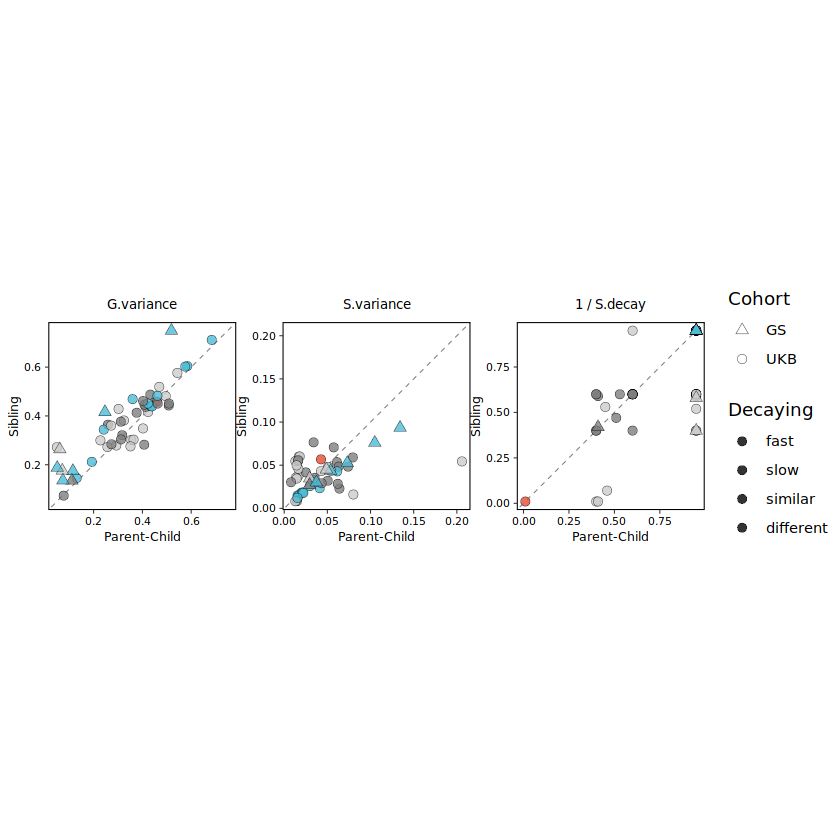

In [13]:
print(combined_plot)

In [111]:
# 파일 저장
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/po-sib.prediction.pdf"
)

ggsave(
    filename = output_path,
    plot = combined_plot,
    width = 183,
    height = 60,
    units = "mm",
    dpi = 300
)